In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.gofplots import qqplot

- In this notebook I present some results from applying the adaptive lasso to a real-world dataset (LISS).
- In total, 8 combinations of parameters were analyzed (cartesian product of the three binary variables: `(add_profession, add_political, january)`), but I think the one that I will present in this notebook is the most general and representative one, since it contains the highest number of regressors from which adaptive lasso can select, and the dependent variable from january (results for july look similar).
- Let's start by importing the already calculated results from the `./bld/analysis` path:

In [2]:
df_full_jan = pd.read_csv(os.path.abspath("../..") + "/bld/analysis/sparse_modelling_adaptive_lasso_add_profession_yes_add_political_yes_january_yes.csv", index_col=0)

In [3]:
df_full_jan.head(15)

,selected_support,theta_nat,lower_conf_bound,upper_conf_bound,variable_name,intercept_value
0,False,0.000000,NaN,NaN,p_2m_infected,NaN
1,False,0.000000,NaN,NaN,p_2m_acquaintance_infected,NaN
2,False,0.000000,NaN,NaN,p_2m_hospital_if_infect_self,NaN
3,False,0.000000,NaN,NaN,p_2m_infected_and_pass_on,NaN
4,False,0.000000,NaN,NaN,nervous_month,NaN
5,False,0.000000,NaN,NaN,depressed_month,NaN
6,False,0.000000,NaN,NaN,calm_month,NaN
7,True,-0.259355,-1.536334,1.017624,gloomy_month,NaN
8,True,-0.475898,-1.676252,0.724457,happy_month,NaN
9,True,16.735916,14.944537,18.527294,covid_health_concern,NaN


In [4]:
df_full_jan[df_full_jan["selected_support"] == True].shape

(52, 6)

- The first column above (*selected_support*) indicates which covariates / regressors have been selected as relevant by the cross-validated adaptive lasso. The so called active set which contains all the corresponding non-zero coefficients for the relevant regressors, in this case make out $\frac{52}{88}$, i.e. we have some sparsity but still many regressors seem to be relevant. 
- The second column (*theta_nat*) lists the estimates for each coefficient by the adaptive lasso procedure.
- The third and fourth column give confidence intervals calculated based on the *Standard Error Formula* given in chapter 3.6 of `Zou, Hui (2006)`.
- The corresponding variable names are listed in the column *variable_name*, and the column *intercept_value* contains a constant (same value for each row) which is the estimated intercept from the adaptive lasso, if an intercept was trained. In this case (due to multicollinearity), no intercept was trained.

- Going back to the *active set*: this set shrinks drastically if we apply the estimated asymptotic 95 % confidence intervals from the adaptive lasso for each coefficient, thus determining which coefficients are significantly different from zero:

In [32]:
# selecting significant coefficients
neg_significant_coeffs = df_full_jan[(df_full_jan["lower_conf_bound"]<0) & (df_full_jan["upper_conf_bound"]<0)]
pos_significant_coeffs = df_full_jan[(df_full_jan["lower_conf_bound"]>0) & (df_full_jan["upper_conf_bound"]>0)]
neg_significant_coeffs

,selected_support,theta_nat,lower_conf_bound,upper_conf_bound,variable_name,intercept_value
14,True,-6.683745,-9.359611,-4.007879,work_status_employed,NaN
31,True,-6.676991,-13.067390,-0.286592,comply_curfew_self_no,NaN
43,True,-19.678871,-35.931314,-3.426428,comply_curfew_self_no:disobey_bc_unaffected,NaN
53,True,-1.848975,-3.684479,-0.013472,approp_gov_communication,NaN
59,True,-1.321340,-2.387277,-0.255402,hh_members,NaN
75,True,-10.022922,-19.950826,-0.095018,profession_unskilled_manual_work,NaN
78,True,-6.885410,-12.939092,-0.831729,"origin_First generation foreign, non-western b...",NaN


In [33]:
pos_significant_coeffs

,selected_support,theta_nat,lower_conf_bound,upper_conf_bound,variable_name,intercept_value
9,True,16.735916,14.944537,18.527294,covid_health_concern,NaN
10,True,9.930806,8.138759,11.722854,covid_vaccine_effective,NaN
39,True,22.082987,0.213388,43.952587,comply_curfew_self_no:disobey_bc_not_punish,NaN


- The set of significantly non-zero coefficients contains only $10$ elements.
- This sharp reduction is probably due to the many binary variables, which create some relatively small subsets within the sample and thus widens the confidence intervals.
- The most obvious and highly significant coefficients are *covid_health_concern* and *covid_vaccine_effective*. But we also encounter some surprises such as the significantly negative impact of *work_status_employed* on the intention to take a vaccine.
- One word of caution: Even though the adaptive lasso is an oracle procedure for large sample sizes going to infinity, which means consistency in variable selection (chooses the right set of relevant variables) and asymptotic  normality around the true coefficients, there are still some assumptions we need to make: The linear model should be close to the truth (i.e. no model misspecifation) and no heteroscedasticity (but we do not assume a normal distribution of the error term in the true model). However, `Wagener, Jens, and Holger Dette (2012)` demonstrate that the basic properties with respect to model selection and parameter estimation of the adaptive lasso do not change if the assumption of homoscedasticity is violated.
- A problem that becomes visible here are the large confidence intervals for some of the coefficients which can be attributed to the fact that subgroups formed by the binary variables reduce the available sample for that variable really quick, but also attributed to the problem of merging several datasets, which results in a reduced intersection of available data.

Let's have a further look into some measures of the estimated errors and dependent values:

In [5]:
# read in the original (cleaned) data:
data = pd.read_csv(os.path.abspath("../..") + "/bld/data/sparse_modelling_df_add_profession_yes_add_political_yes.csv")
data = data.drop(["personal_id"], axis=1)

y = data[["vaccine_intention_jan"]]
X = data.drop(["vaccine_intention_jan", "vaccine_intention_jul"], axis=1)

y_numpy = y.to_numpy()
X_numpy = X.to_numpy()

In [6]:
# get estimates for y-values and residuals, given the estimated coefficients in theta_nat
y_hat_full_jan = X_numpy @ df_full_jan["theta_nat"].to_numpy().reshape((len(df_full_jan["theta_nat"]),1))
residuals_hat = y_numpy.flatten() - y_hat_full_jan.flatten()

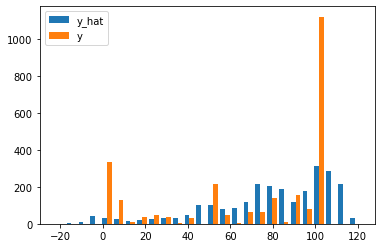

In [8]:
# plot histograms for the original y-values and the estimated ones from the adaptive lasso model:
plt.hist([y_hat_full_jan.flatten(), y_numpy.flatten()], bins='auto', label=['y_hat', 'y'])
plt.legend(loc='upper left')
plt.show()

- The boundedness of the dependent variable (original y-values, 0 - 100) is visible. However, since inference and not prediction is our goal, this should not be a major issue.
- Also, the original data $y$ shares characteristics of a bimodal/ trimodal distribution (peaks at 0, 50, and 100), which would make a quantile regression approach interesting.

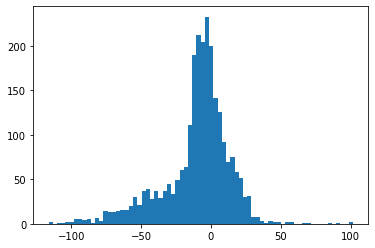

In [9]:
# plot a histograms for the estimated residuals:
_ = plt.hist(residuals_hat, bins='auto')
plt.show()

- This distribution of estimated residuals seems alright for the adaptive lasso assumptions

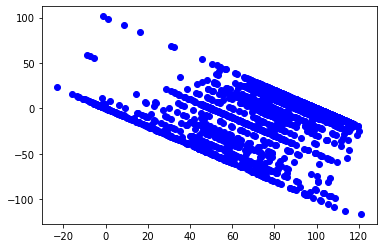

In [10]:
# concerning heteroscedasticity, we want to inspect a plot of estimated residuals (y-axis) on the predicted y-values (x-axis):
_ = plt.plot(y_hat_full_jan, residuals_hat, 'bo')
plt.show()

- This looks like homoscedasticity cannot be assumed in our data.

- In conclusion, I think the adaptive lasso is a suitable method to analyse the joint effect of all relevant regressors (from a larger set of possible regressors) on the vaccination attitude (dependent variable) of participants. 
- Further support for the method can be derived from the good simulation results on a data generating process that was motivated by the real LISS panel data (see `sim_study_results.ipynb`).
- However, there is still room for improvement, such as making use of a (penalized) quantile regression, since with our bimodal / trimodal response, the conditional mean might not be the major object of interest. With quantile regressio, one could regress on the quantiles that are peaks of our dependent data. The implementation of this advanced procedures was however not feasible in the given time. For more information, have a look at `Wu, Yichao, and Yufeng Liu (2009)`.